In [ ]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from typing import TypedDict, Annotated, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field
load_dotenv()

True

In [2]:
model = ChatGroq(model='openai/gpt-oss-120b')
model

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001FB68F586D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001FB690A8390>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
class SentimentSchema(BaseModel):
    sentiment : Literal["positive", "negative"] = Field(description="Sentiment of the review")

In [4]:
structed_model = model.with_structured_output(SentimentSchema)
structed_model

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001FB68F586D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001FB690A8390>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'SentimentSchema', 'description': '', 'parameters': {'properties': {'sentiment': {'description': 'Sentiment of the review', 'enum': ['positive', 'negative'], 'type': 'string'}}, 'required': ['sentiment'], 'type': 'object'}}}], 'ls_structured_output_format': {'kwargs': {'method': 'function_calling'}, 'schema': {'type': 'function', 'function': {'name': 'SentimentSchema', 'description': '', 'parameters': {'properties': {'sentiment': {'description': 'Sentiment of the review', 'enum': ['positive', 'negative'], 'type': 'string'}}, 'required': ['sentiment'], 'type': 'object'}}}}, 'tool_choice': {'type': 'function', 'function': {'name': 'Sent

In [5]:
class ReviesState(TypedDict):
    review : str
    sentiment : Literal["negative", "positive"]
    diagnosis : dict
    responses : str


In [6]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description="The category of issue mentioned in the review")
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description="The emotional tone expressed by the user")
    urgency: Literal["low", "medium", "high"] = Field(description="How urgent or critical the issue appears to be")


In [7]:
structed_model2 = model.with_structured_output(DiagnosisSchema)
structed_model2

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001FB68F586D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001FB690A8390>, model_name='openai/gpt-oss-120b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'DiagnosisSchema', 'description': '', 'parameters': {'properties': {'issue_type': {'description': 'The category of issue mentioned in the review', 'enum': ['UX', 'Performance', 'Bug', 'Support', 'Other'], 'type': 'string'}, 'tone': {'description': 'The emotional tone expressed by the user', 'enum': ['angry', 'frustrated', 'disappointed', 'calm'], 'type': 'string'}, 'urgency': {'description': 'How urgent or critical the issue appears to be', 'enum': ['low', 'medium', 'high'], 'type': 'string'}}, 'required': ['issue_type', 'tone', 'urgency'], 'type': 'object'}}}], 'ls_structured_output_format': {'kwargs': {'method': 'function_calling'},

In [8]:
def find_sentiment(state : ReviesState):
    prompt = f"for the following review find out the sentiment \n {state['review']}"
    sentiment = structed_model.invoke(prompt).sentiment
    return {'sentiment' : sentiment}

In [9]:
def check_sentiment(state : ReviesState) -> Literal["positive_responses", "run_diagnosis"]:
    if state["sentiment"] == 'positive':
        return "positive_responses"
    else:
        return "run_diagnosis"

In [10]:
def positive_responses(state : ReviesState):
    prompt = f"""Write a warm thank-you message in response to this review:
{state['review']}
Also, kindly ask the user to leave feedback on our website."""
    responses = model.invoke(prompt).content
    return {'responses' : responses}


In [11]:
def run_diagnosis(state : ReviesState):
    prompt = f""" 
Diagnose this negative review: \n\n {state['review']}\n
Return issue_type, tone and ungency
"""
    responses = structed_model2.invoke(prompt)
    return {'diagnosis' : responses.model_dump()}

In [12]:
def negative_responses(state : ReviesState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message."""
    responses = model.invoke(prompt).content
    return {'responses' : responses}


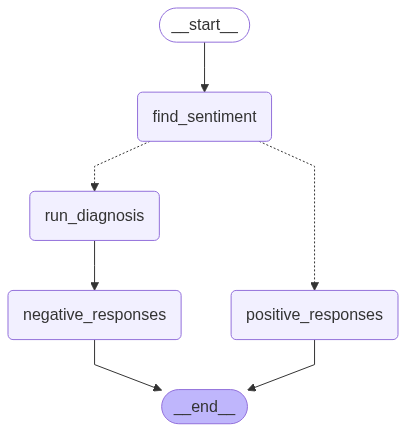

In [13]:
graph = StateGraph(ReviesState)
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_responses', positive_responses)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_responses', negative_responses)

graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_responses', END)
graph.add_edge('run_diagnosis', 'negative_responses')

graph.add_edge('find_sentiment', END)

workflow = graph.compile()
workflow

In [14]:
initial_state={'review' : "I've been using this app for about a month now, and honestly, the user interface feels clunky and confusing. Nothing is where you'd expect it to be. I kept having to search online just to figure out basic features. It's frustrating when something that should be simple turns into a chore. Really disappointed with the design choices."}
workflow.invoke(initial_state)


{'review': "I've been using this app for about a month now, and honestly, the user interface feels clunky and confusing. Nothing is where you'd expect it to be. I kept having to search online just to figure out basic features. It's frustrating when something that should be simple turns into a chore. Really disappointed with the design choices.",
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'UX', 'tone': 'frustrated', 'urgency': 'medium'},
 'responses': 'Hi there,\n\nI’m really sorry you’re running into a frustrating experience with the product’s user interface. I understand how disruptive that can be, especially when you’re trying to get things done.\n\n**Let’s get this sorted out together.**  \nBelow are a few quick checks that often resolve common UX hiccups. If any of these don’t help, just let me know and we’ll dive deeper.\n\n---\n\n### 1. Refresh & Clear Cache  \n- **Refresh the page** (or restart the app).  \n- **Clear your browser cache** (or app data) – stale files c